In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf
#from tensorflow import set_random_seed
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.models import Sequential
from keras import optimizers


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2657 sha256=876725e20753f16ef0e23e1e06d37957945f3f41036346adb792178242d4d2bf
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN,GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras import optimizers
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path ='/content/drive/MyDrive/ICAS/normal_overtaking.csv'
train = pd.read_csv(path,usecols=[18,19,20,30,31,32])
last=(train.shape[0]//3)*3
train=train[0:last]
train

,angular_velocity.x,angular_velocity.y,angular_velocity.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z
0,0.001359,0.002366,0.000258,0.961052,-0.245166,9.796843
1,-0.002334,0.003354,0.001427,0.490333,-0.245166,9.894910
2,-0.003173,0.002272,0.002434,0.284393,-0.156906,9.855683
3,-0.002579,0.002873,0.002923,0.696272,-0.313813,9.904716
4,-0.000993,0.003704,0.002703,0.872792,-0.284393,9.708584
...,...,...,...,...,...,...
856,0.000282,0.000079,0.000286,0.284393,-0.225553,9.845877
857,0.000133,0.000561,0.000801,0.245166,-0.205940,9.845877
858,-0.001297,0.001588,0.001245,0.254973,-0.147100,9.855683
859,-0.001468,0.001852,0.000171,0.304006,-0.166713,9.885103


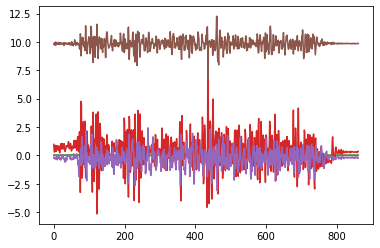

In [ ]:
# plot the variation vs time i
plt.plot(train)

In [ ]:
path ='/content/drive/MyDrive/ICAS/abnormal.csv'
test = pd.read_csv(path,usecols=[18,19,20,30,31,32])
test=test[0:(test.shape[0]//3)*3]
test.index=test.index+last
test

,angular_velocity.x,angular_velocity.y,angular_velocity.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z
861,0.001369,0.003281,-0.003239,0.421686,-0.215746,9.885103
862,-0.000466,0.002388,-0.003293,0.411879,-0.294199,9.875297
863,-0.001836,0.002453,-0.002719,0.411879,-0.304006,9.894910
864,-0.001633,0.004359,-0.001778,0.411879,-0.294199,9.875297
865,0.000206,0.005041,-0.002078,0.402073,-0.264780,9.885103
...,...,...,...,...,...,...
2302,-0.001603,0.001664,-0.001208,0.451106,-0.392266,9.875297
2303,-0.001596,0.002113,-0.002849,0.362846,-0.392266,9.826263
2304,-0.001849,0.004086,-0.001547,0.284393,-0.451106,9.855683
2305,-0.001895,0.003308,-0.000129,0.284393,-0.382459,9.865490


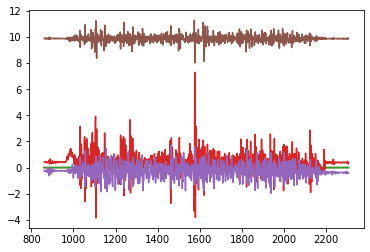

In [ ]:
# plot the variation vs time i
plt.plot(test)

In [ ]:
#train = train[1: 700]
#test = data[701:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (861, 6)
Test dataset shape: (1446, 6)


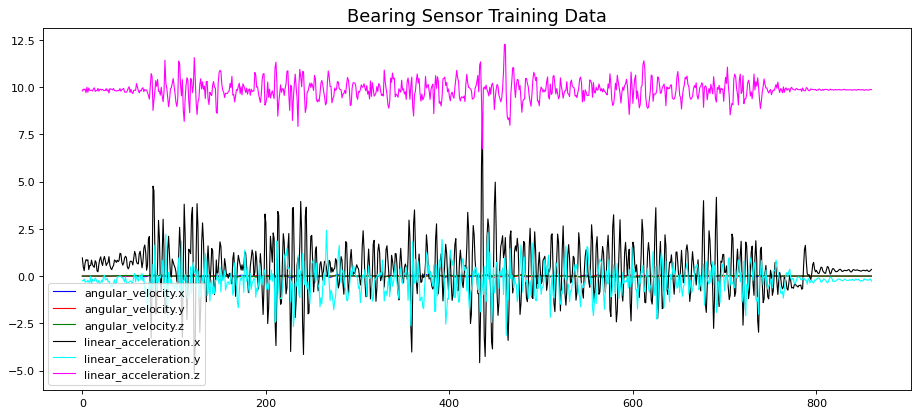

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['angular_velocity.x'], label='angular_velocity.x', color='blue', animated = True, linewidth=1)
ax.plot(train['angular_velocity.y'], label='angular_velocity.y', color='red', animated = True, linewidth=1)
ax.plot(train['angular_velocity.z'], label='angular_velocity.z', color='green', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.x'], label='linear_acceleration.x', color='black', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.y'], label='linear_acceleration.y', color='cyan', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.z'], label='linear_acceleration.z', color='magenta', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
X_train = X_train.reshape(X_train.shape[0]//3,3, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0]//3,3, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (287, 3, 6)
Test data shape: (482, 3, 6)


In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(3,6))
    L11 =LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_11, state_h_11, state_c_11 = L11(inputs[0])
    encoder_states_11 = [state_h_11, state_c_11]

    L12 = LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_12, state_h_12, state_c_12 = L12(inputs[1],initial_state = encoder_states_11)
    encoder_states_12 = [state_h_12, state_c_12]

    L13 = LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_13, state_h_13, state_c_13 = L13(inputs[2],initial_state = encoder_states_12)
    encoder_states_13 = [state_h_13, state_c_13]

    L21 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_21, state_h_21, state_c_21 = L21(encoder_outputs_11)
    encoder_states_21 = [state_h_21, state_c_21]

    L22 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_22, state_h_22, state_c_22 = L22(encoder_outputs_12,initial_state = encoder_states_21)
    encoder_states_22 = [state_h_22, state_c_22]

    L23 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_23, state_h_23, state_c_23 = L23(encoder_outputs_13,initial_state = encoder_states_22)
    encoder_states_23 = [state_h_23, state_c_23]

    L3 = RepeatVector(64)
    encoder_outputs_3, state_h_3, state_c_3 = L3(L23)

    L41 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_41, state_h_41, state_c_41 = L41(encoder_outputs_3)
    encoder_states_41 = [state_h_41, state_c_41]

    L42 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_42, state_h_42, state_c_42 = L42(encoder_outputs_3,initial_state = encoder_states_L41)
    encoder_states_42 = [state_h_42, state_c_42]

    L43 = LSTM(64, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_43, state_h_43, state_c_43 = L43(encoder_outputs_3,initial_state = encoder_states_L42)
    encoder_states_43 = [state_h_43, state_c_43]

    L51 = LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_51, state_h_51, state_c_51 = L51(encoder_outputs_41)
    encoder_states_51 = [state_h_51, state_c_51]

    L52 = LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_52, state_h_52, state_c_52 = L52(encoder_outputs_42,initial_state = encoder_states_L51)
    encoder_states_52 = [state_h_52, state_c_52]

    L53 = LSTM(128, activation='relu', return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.00))
    encoder_outputs_53, state_h_53, state_c_53 = L53(encoder_outputs_43,initial_state = encoder_states_L52)
    encoder_states_53 = [state_h_53, state_c_53]

    #temp=TimeDistributed(encoder_outputs_51,encoder_outputs_52,encoder_outputs_53)

    output = TimeDistributed(Dense(X.shape[1],X.shape[2], X.shape[3]))(encoder_outputs_53)  
      
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
def autoencoder_model(X):
  time_step = 3
  n_features = 6
  model=Sequential()
  model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=False))
  model.add(RepeatVector(time_step))
  model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(TimeDistributed(Dense(n_features,activation="sigmoid")))
  # plot_model(model, to_file='Submission_LSTM_autoencoder.png', show_shapes=True,show_layer_names=False)
  model.compile(optimizer=optimizers.Adam(lr=0.01),loss="mse")
  return model

In [ ]:
model = autoencoder_model(X_train)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 3, 128)            69120     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_23 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 3, 6)              774       
Total params: 251,142
Trainable params: 251,142
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
28/28 [==============================] - 28s 87ms/step - loss: 0.0172 - val_loss: 0.0011
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.0011
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 9.5091e-04
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 1.5828e-04
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 8/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 1.6188e-04
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 3.6856e-04
Epoch 10/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0064 -

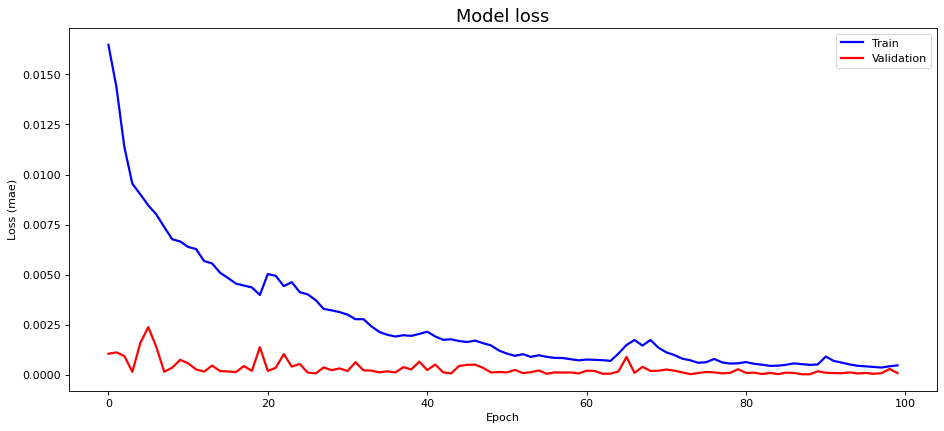

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

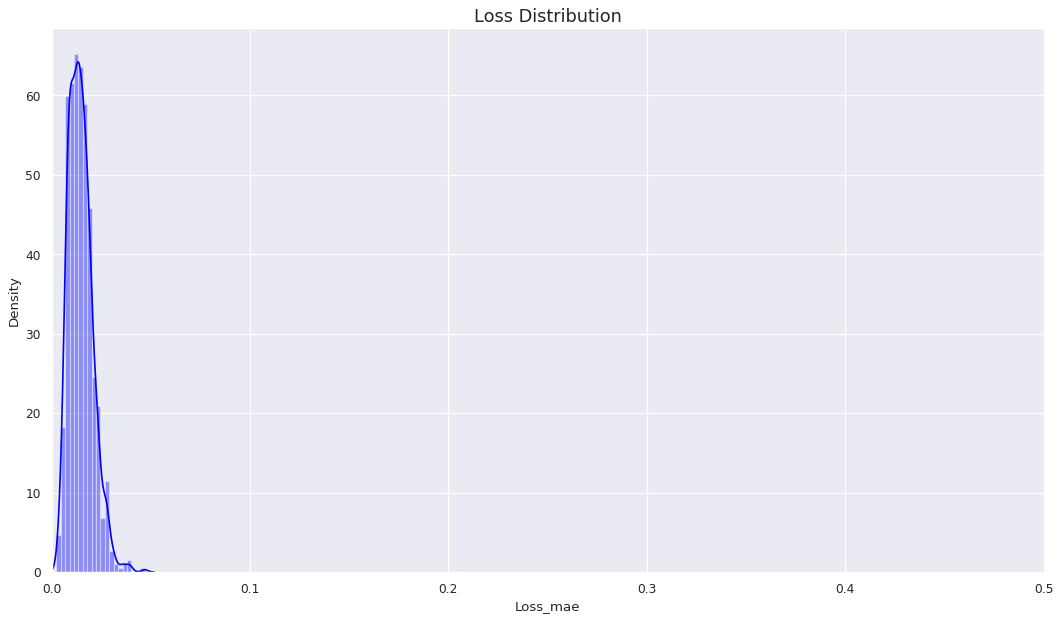

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
print(scored['Loss_mae'].shape)
scored['Threshold'] = 0.05
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

(1446,)


,Loss_mae,Threshold,Anomaly
861,0.009417,0.05,False
862,0.007407,0.05,False
863,0.009461,0.05,False
864,0.009024,0.05,False
865,0.006489,0.05,False


In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0]* X_pred_train.shape[1],X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
print(scored_train['Loss_mae'].shape)
scored_train['Threshold'] = 0.05
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_fin = pd.concat([scored_train, scored],axis=0)
print(scored_fin['Loss_mae'].shape)
scored_train.head()

(861,)
(2307,)


,Loss_mae,Threshold,Anomaly
0,0.011008,0.05,False
1,0.007149,0.05,False
2,0.009970,0.05,False
3,0.008941,0.05,False
4,0.011723,0.05,False


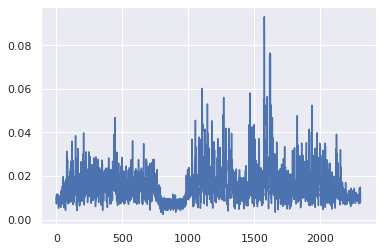

In [ ]:
plt.plot(scored_fin['Loss_mae'])

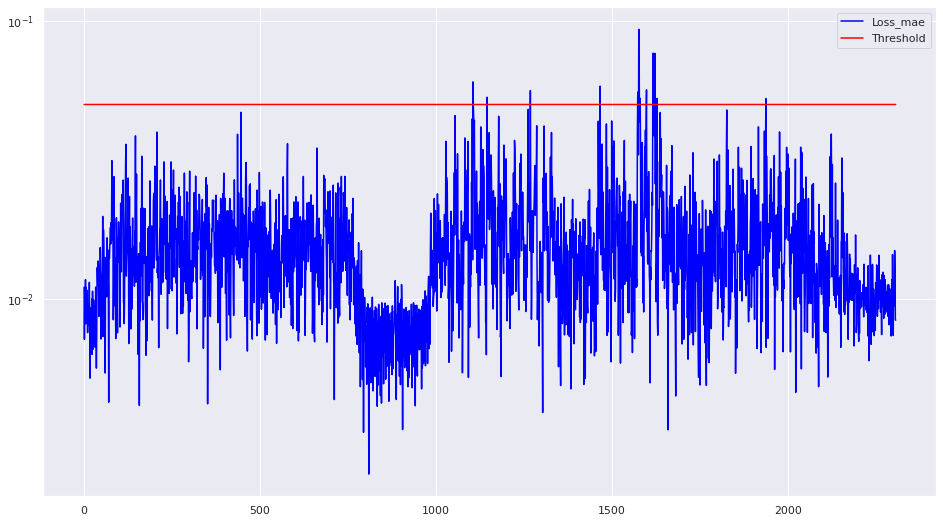

In [ ]:
# plot bearing failure time plot
scored_fin.plot(logy=True,  figsize=(16,9), color=['blue','red'])

In [ ]:

# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved


In [ ]:

x_t= pd.DataFrame()
for num in [0]:

    

    path ='/content/drive/MyDrive/ICAS/normal_overtaking.csv'
    train = pd.read_csv(path,usecols=[18,19,20,30,31,32])
    last=(train.shape[0]//3)*3
    df=train[0:last]


    for i in range(len(df)):
       
        xa=df["angular_velocity.x"][i]
        ya=df["angular_velocity.y"][i]
        za=df["angular_velocity.z"][i]
        xl=df["linear_acceleration.x"][i]
        yl=df["linear_acceleration.y"][i]
        zl=df["linear_acceleration.z"][i]-10
        
        imu=np.array([xa,ya,za,xl,yl,zl])
        imu_df=pd.DataFrame(imu.reshape(1,len(imu)))
        imu_df.index=[str(i)]
        x_t=x_t.append(imu_df)
      
x_t.columns=["XA","YA","ZA","XL","YL","ZL"]
x_t_s=pd.DataFrame(scaler.transform(x_t))

x_t.describe()
z=np.array(x_t_s)
look_back=3
x_test=[]
y_test=[]

for i in range(len(z)-look_back):
    temp=[]
    for j in range(look_back):
        temp.append(z[i+j])
    x_test.append(temp)
    y_test.append(z[i+look_back])
  
x_test=np.array(x_test)
y_test=np.array(y_test)

x_test2=np.zeros((x_test.shape[0],1,n_features))
x_pred = model.predict([x_test])


a_error=[]
l_error=[]
for i in range(len(x_test)):
    error_vector=np.abs(x_pred[i][0]-y_test[i])
    a=np.mean(error_vector[:3],axis=0)
    l=np.mean(error_vector[3:],axis=0)

    a_error.append(a)
    l_error.append(l)
    # print(error_vector,a,l)
a_error=np.array(a_error)
l_error=np.array(l_error)

In [ ]:
 print("a_error ",a_error.shape)

print("l_error ",l_error.shape)

a_error  (858,)
l_error  (858,)


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme","beta","betaprime","bradford","burr","burr12","cauchy","chi","chi2","cosine","dgamma","alpha",
                  "dweibull","erlang","expon","exponweib","exponpow","fatiguelife","fisk",
                  "cauchy","foldnorm","f","genlogistic","gamma","genpareto","genexpon","genextreme",
                  "gengamma","genhalflogistic","gennorm","gilbrat","gompertz","gumbel_r",
                  "gumbel_l","halfcauchy","halfnorm","halflogistic","hypsecant","gausshyper","invgamma","invgauss",
                  "invweibull","johnsonsb","ksone","kstwobign","levy_l",
                  "levy","loglaplace","loggamma","lognorm","maxwell","mielke",
                  "nakagami","ncx2","pareto","lomax","powernorm",
                  "powerlaw","rdist","rayleigh","rice","recipinvgauss","semicircular",
                  "t","trapz","triang","truncexpon","truncnorm",
                  "tukeylambda","vonmises","uniform","wald","weibull_max","weibull_min","logistic","nct","norminvgauss","johnsonsu"]#,"johnsonsu"

    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        #print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    # print("Best fitting distribution: "+str(best_dist))
    # print("Best p value: "+ str(best_p))
    # print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

%matplotlib inline


matplotlib.rcParams['figure.figsize'] = (16.0, 14.0)
matplotlib.style.use('ggplot')

'''This function can be used to plot the histogram of the a-error and l-error and the original distribution on the same figure'''
def Plot(data,dist):
    bins = 100
    size = 16384
    DISTRIBUTIONS = [dist]
    plotData = []
    for distribution in DISTRIBUTIONS:
        # Create random data
        rv = pd.Series(data)
        # Get sane start and end points of distribution
        start = distribution.ppf(0)
        end = distribution.ppf(0.99)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = distribution.pdf(x)
        pdf = pd.Series(y, x)

        # Get histogram of random data
        b = np.linspace(start, end, bins+1)
        y, x = np.histogram(rv, bins=b, normed=True)
        x = [(a+x[i+1])/2.0 for i,a in enumerate(x[0:-1])]
        hist = pd.Series(y, x)

        # Create distribution name and parameter string
        title = '{}({})'.format(distribution.dist.name, ', '.join(['{}={:0.2f}'.format(k,v) for k,v in distribution.kwds.items()]))

        # Store data for later
        plotData.append({
        'pdf': pdf,
        'hist': hist,
        'title': title
        })


        plotMax = len(plotData)

    for i, data in enumerate(plotData):
        w = abs(abs(data['hist'].index[0]) - abs(data['hist'].index[1]))

        # Display
        plt.figure(figsize=(10, 6))
        ax = data['pdf'].plot(kind='line', label='Model PDF', legend=True, lw=2)
        ax.bar(data['hist'].index, data['hist'].values, label='Random Sample', width=w, align='center', alpha=0.5)
        ax.set_title(data['title'])
        plt.savefig("linear_acceleration_reconstruction_error")


In [ ]:
'''this function is going to return the best distribution and the parameters for the distribution, we need to
copy and paste both to the next cell's "valid" variable
'''
d=a_error
get_best_distribution(d)

('fisk',
 0.6627990376024111,
 (10.708323429059604, -0.18383631623087526, 0.366744716994071))

0.6549428202749505


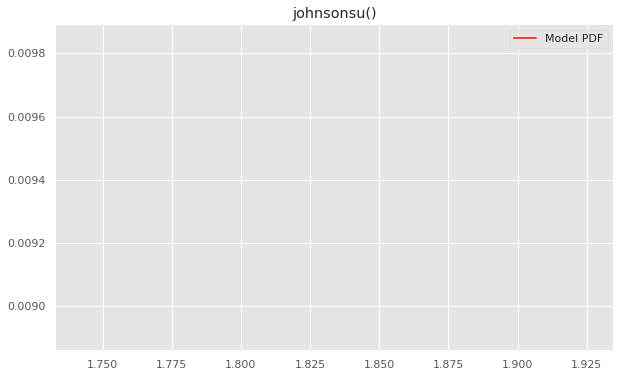

In [ ]:
'''from the output of the above cell, the name of the distribution and the parameters are used in the valid variable,
to find the threshold using stats."name_of_distribution"(parameters)
'''
valid = stats.johnsonsu(-1.5073536157441059,
  0.6241443415220735,
  0.05962669620839295,
  0.007628070045993433)
Plot(d,valid) # this is to plot the histogram of the data along with the fitted distribution
threshold=valid.ppf(0.95)
tang=threshold
print(threshold)

In [ ]:
'''this function is going to return the best distribution and the parameters for the distribution, we need to
copy and paste both to the next cell's "valid" variable
'''
d=l_error
get_best_distribution(d)

('burr12',
 0.2187482777267265,
 (14942.013301350125,
  0.4267202905653662,
  -335.1168064761466,
  335.6772812223794))

0.3215378894922224


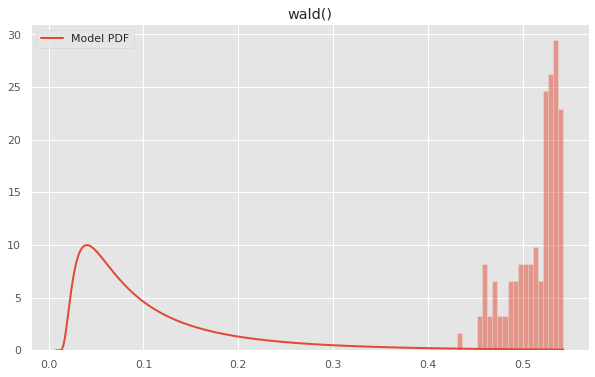

In [ ]:
'''from the output of the above cell, the name of the distribution and the parameters are used in the valid variable,
to find the threshold using stats."name_of_distribution"(parameters)
'''
valid = stats.wald(0.007817387357488336, 0.10736219885285664)
Plot(d,valid) # this is to plot the histogram of the data along with the fitted distribution
threshold=valid.ppf(0.95)
tlin=threshold
print(threshold)